In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
pip install SimpleITK

     |████████████████████████████████| 47.4MB 66kB/s 


In [ ]:
import SimpleITK as sitk

In [ ]:

if K.image_data_format() == 'th':
  input_tensor = Input(shape=(3, 240, 240)) 


img_size=240   #original img size is 240*240
smooth = 0.005 
num_of_aug = 2
num_epoch = 30
pul_seq = 'Flair'
sharp = False       # sharpen filter
LR = 1e-4

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis+NET, 2 = tumor core,3= original, 4 = ET, 5 = complete tumor
'''
0: other
1: necrosis + NET
2: edema
4: enhancing tumor
5: full tumor
'''

'\n0: other\n1: necrosis + NET\n2: edema\n4: enhancing tumor\n5: full tumor\n'

In [ ]:
import glob
def create_data(src, mask, label=False, resize=(128,img_size,img_size)):
    files = glob.glob(src + mask, recursive=True)
    r.seed(9)
    r.shuffle(files)    # shuffle patients
    imgs = []
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        #img = trans.resize(img, resize, mode='constant')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis and NET
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            if label_num == 3:
                img[img == 3] = 1       # remain GT, design for 2015 data
                
                
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
            img = img.astype('float32')
        for slice in range(60,130):     #choose the slice range
            img_t = img[slice,:,:]
            img_t =img_t.reshape((1,)+img_t.shape)
            img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
            #img_g = augmentation(img_t,num_of_aug)
            for n in range(img_t.shape[0]):
                imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [ ]:
#function to read one subject data
def create_data_onesubject_val(src, mask,count, label=False):
    files = glob.glob(src + mask, recursive=True)
    r.seed(9)
    r.shuffle(files)    # shuffle patients
    k = len(files) - count -1
    imgs = []
    file = files[k]
    print('Processing---', mask,'--',file)
    
    img = io.imread(file, plugin='simpleitk')
    #img = trans.resize(img, resize, mode='constant')
    if label:
        if label_num == 5:
            img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
        if label_num == 1:
            img[img != 1] = 0       #only left necrosis
        if label_num == 2:
            img[img == 2] = 0       #turn edema to 0
            img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
        if label_num == 4:
            img[img != 4] = 0       #only left ET
            img[img == 4] = 1
        img = img.astype('float32')
    else:
        img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
        img = img.astype('float32')
    for slice in range(155):     #choose the slice range
        img_t = img[slice,:,:]
        img_t =img_t.reshape((1,)+img_t.shape)
        img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
        #img_g = augmentation(img_t,num_of_aug)
        for n in range(img_t.shape[0]):
            imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [ ]:
#read one subject to show slices
count = 50
pul_seq = 'flair'
Flair = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1ce'
T1c = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1'
T1 = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't2'
T2 = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
label_num = 5
Label_full = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*seg.nii.gz', count, label=True)
label_num = 2
Label_core = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*seg.nii.gz', count, label=True)
label_num = 4
Label_ET = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*seg.nii.gz', count, label=True)
label_num = 3
Label_all = create_data_onesubject_val('/content/drive/MyDrive/Brats/HGG/', '**/*seg.nii.gz', count, label=True)

Processing--- **/*flair.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_flair.nii.gz
Processing--- **/*t1ce.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_t1ce.nii.gz
Processing--- **/*t1.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_t1.nii.gz
Processing--- **/*t2.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_t2.nii.gz
Processing--- **/*seg.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- /content/drive/MyDrive/Brats/HGG/BraTS19_TCIA06_409_1/BraTS19_TCIA06_409_1_seg.nii.gz


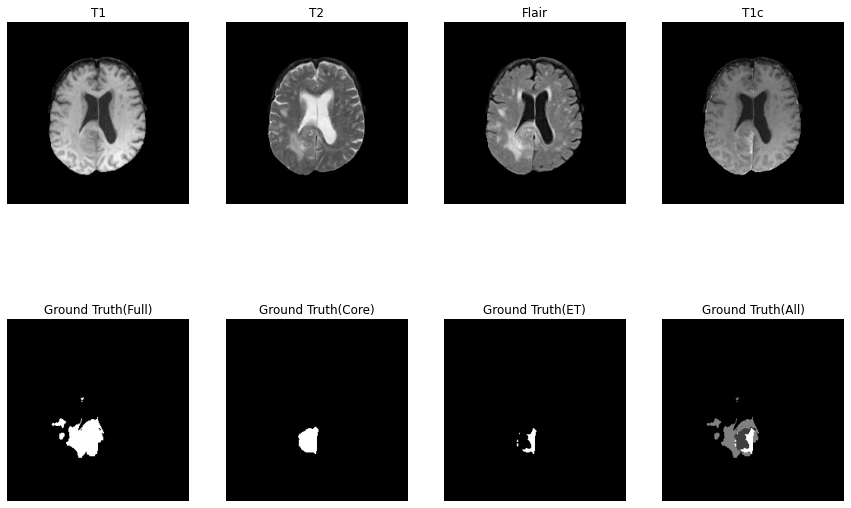

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(241)
plt.title('T1')
plt.axis('off')
plt.imshow(T1[90, 0, :, :],cmap='gray')

plt.subplot(242)
plt.title('T2')
plt.axis('off')
plt.imshow(T2[90, 0, :, :],cmap='gray')
    
plt.subplot(243)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair[90, 0, :, :],cmap='gray')

plt.subplot(244)
plt.title('T1c')
plt.axis('off')
plt.imshow(T1c[90, 0, :, :],cmap='gray')

plt.subplot(245)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(Label_full[90, 0, :, :],cmap='gray')

plt.subplot(246)
plt.title('Ground Truth(Core)')
plt.axis('off')
plt.imshow(Label_core[90, 0, :, :],cmap='gray')

plt.subplot(247)
plt.title('Ground Truth(ET)')
plt.axis('off')
plt.imshow(Label_ET[90, 0, :, :],cmap='gray')

plt.subplot(248)
plt.title('Ground Truth(All)')
plt.axis('off')
plt.imshow(Label_all[90, 0, :, :],cmap='gray')

plt.show()

In [ ]:
# our U-net for full tumor segmentation
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
def unet_model():
    inputs = Input((2, img_size, img_size))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=LR), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model = unet_model()

ValueError: ignored